# Walmart Sales Forecasting - Exploratory Data Analysis

## Overview
This notebook performs comprehensive exploratory data analysis on the Walmart Sales dataset to understand:
- Data structure and quality
- Sales patterns and trends
- Seasonal effects
- Store and department characteristics
- External factors impact

## Dataset Description
- **train.csv**: Historical sales data with weekly sales by store and department
- **features.csv**: Additional features like temperature, fuel price, markdowns, CPI, unemployment
- **stores.csv**: Store metadata including type and size
- **test.csv**: Test set for predictions

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import os

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Inspection

In [2]:
# Load datasets
train_df = pd.read_csv('../data/raw/train.csv')
features_df = pd.read_csv('../data/raw/features.csv')
stores_df = pd.read_csv('../data/raw/stores.csv')
test_df = pd.read_csv('../data/raw/test.csv')

print("Dataset shapes:")
print(f"Train: {train_df.shape}")
print(f"Features: {features_df.shape}")
print(f"Stores: {stores_df.shape}")
print(f"Test: {test_df.shape}")

Dataset shapes:
Train: (421570, 5)
Features: (8190, 12)
Stores: (45, 3)
Test: (115064, 4)


In [3]:
# Display basic information about each dataset
print("=== TRAIN DATASET ===")
print(train_df.info())
print("\nFirst 5 rows:")
print(train_df.head())
print("\nBasic statistics:")
print(train_df.describe())

=== TRAIN DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

First 5 rows:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Basic statistics:
               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317

In [4]:
print("=== FEATURES DATASET ===")
print(features_df.info())
print("\nFirst 5 rows:")
print(features_df.head())
print("\nBasic statistics:")
print(features_df.describe())

=== FEATURES DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None

First 5 rows:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.

In [5]:
print("=== STORES DATASET ===")
print(stores_df.info())
print("\nAll stores:")
print(stores_df)
print("\nStore type distribution:")
print(stores_df['Type'].value_counts())

=== STORES DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None

All stores:
    Store Type    Size
0       1    A  151315
1       2    A  202307
2       3    B   37392
3       4    A  205863
4       5    B   34875
5       6    A  202505
6       7    B   70713
7       8    A  155078
8       9    B  125833
9      10    B  126512
10     11    A  207499
11     12    B  112238
12     13    A  219622
13     14    A  200898
14     15    B  123737
15     16    B   57197
16     17    B   93188
17     18    B  120653
18     19    A  203819
19     20    A  203742
20     21    B  140167
21     22    B  119557
22     23    B  114533
23     24    A  203819
24     25    B  128107
25     26    A  152513
26    

## 2. Data Quality Assessment

In [6]:
# Check for missing values
def check_missing_values(df, name):
    print(f"\n=== Missing Values in {name} ===")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("No missing values found!")
    return missing_df

train_missing = check_missing_values(train_df, "Train")
features_missing = check_missing_values(features_df, "Features")
stores_missing = check_missing_values(stores_df, "Stores")
test_missing = check_missing_values(test_df, "Test")


=== Missing Values in Train ===
No missing values found!

=== Missing Values in Features ===
              Missing Count  Missing %
MarkDown2              5269  64.334554
MarkDown4              4726  57.704518
MarkDown3              4577  55.885226
MarkDown1              4158  50.769231
MarkDown5              4140  50.549451
CPI                     585   7.142857
Unemployment            585   7.142857

=== Missing Values in Stores ===
No missing values found!

=== Missing Values in Test ===
No missing values found!


In [7]:
# Convert date columns to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Check date ranges
print("Date ranges:")
print(f"Train: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"Features: {features_df['Date'].min()} to {features_df['Date'].max()}")
print(f"Test: {test_df['Date'].min()} to {test_df['Date'].max()}")

# Check for duplicate records
print(f"\nDuplicate records:")
print(f"Train duplicates: {train_df.duplicated().sum()}")
print(f"Features duplicates: {features_df.duplicated().sum()}")
print(f"Stores duplicates: {stores_df.duplicated().sum()}")

Date ranges:
Train: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Features: 2010-02-05 00:00:00 to 2013-07-26 00:00:00
Test: 2012-11-02 00:00:00 to 2013-07-26 00:00:00

Duplicate records:
Train duplicates: 0
Features duplicates: 0
Stores duplicates: 0


## 3. Sales Data Analysis

In [8]:
# Basic sales statistics
print("=== SALES STATISTICS ===")
print(f"Total sales records: {len(train_df):,}")
print(f"Unique stores: {train_df['Store'].nunique()}")
print(f"Unique departments: {train_df['Dept'].nunique()}")
print(f"Date range: {(train_df['Date'].max() - train_df['Date'].min()).days} days")
print(f"Total sales volume: ${train_df['Weekly_Sales'].sum():,.2f}")
print(f"Average weekly sales: ${train_df['Weekly_Sales'].mean():,.2f}")
print(f"Median weekly sales: ${train_df['Weekly_Sales'].median():,.2f}")

# Check for negative sales
negative_sales = train_df[train_df['Weekly_Sales'] < 0]
print(f"\nNegative sales records: {len(negative_sales)} ({len(negative_sales)/len(train_df)*100:.2f}%)")
if len(negative_sales) > 0:
    print(f"Negative sales range: ${negative_sales['Weekly_Sales'].min():,.2f} to ${negative_sales['Weekly_Sales'].max():,.2f}")

=== SALES STATISTICS ===
Total sales records: 421,570
Unique stores: 45
Unique departments: 81
Date range: 994 days
Total sales volume: $6,737,218,987.11
Average weekly sales: $15,981.26
Median weekly sales: $7,612.03

Negative sales records: 1285 (0.30%)
Negative sales range: $-4,988.94 to $-0.02


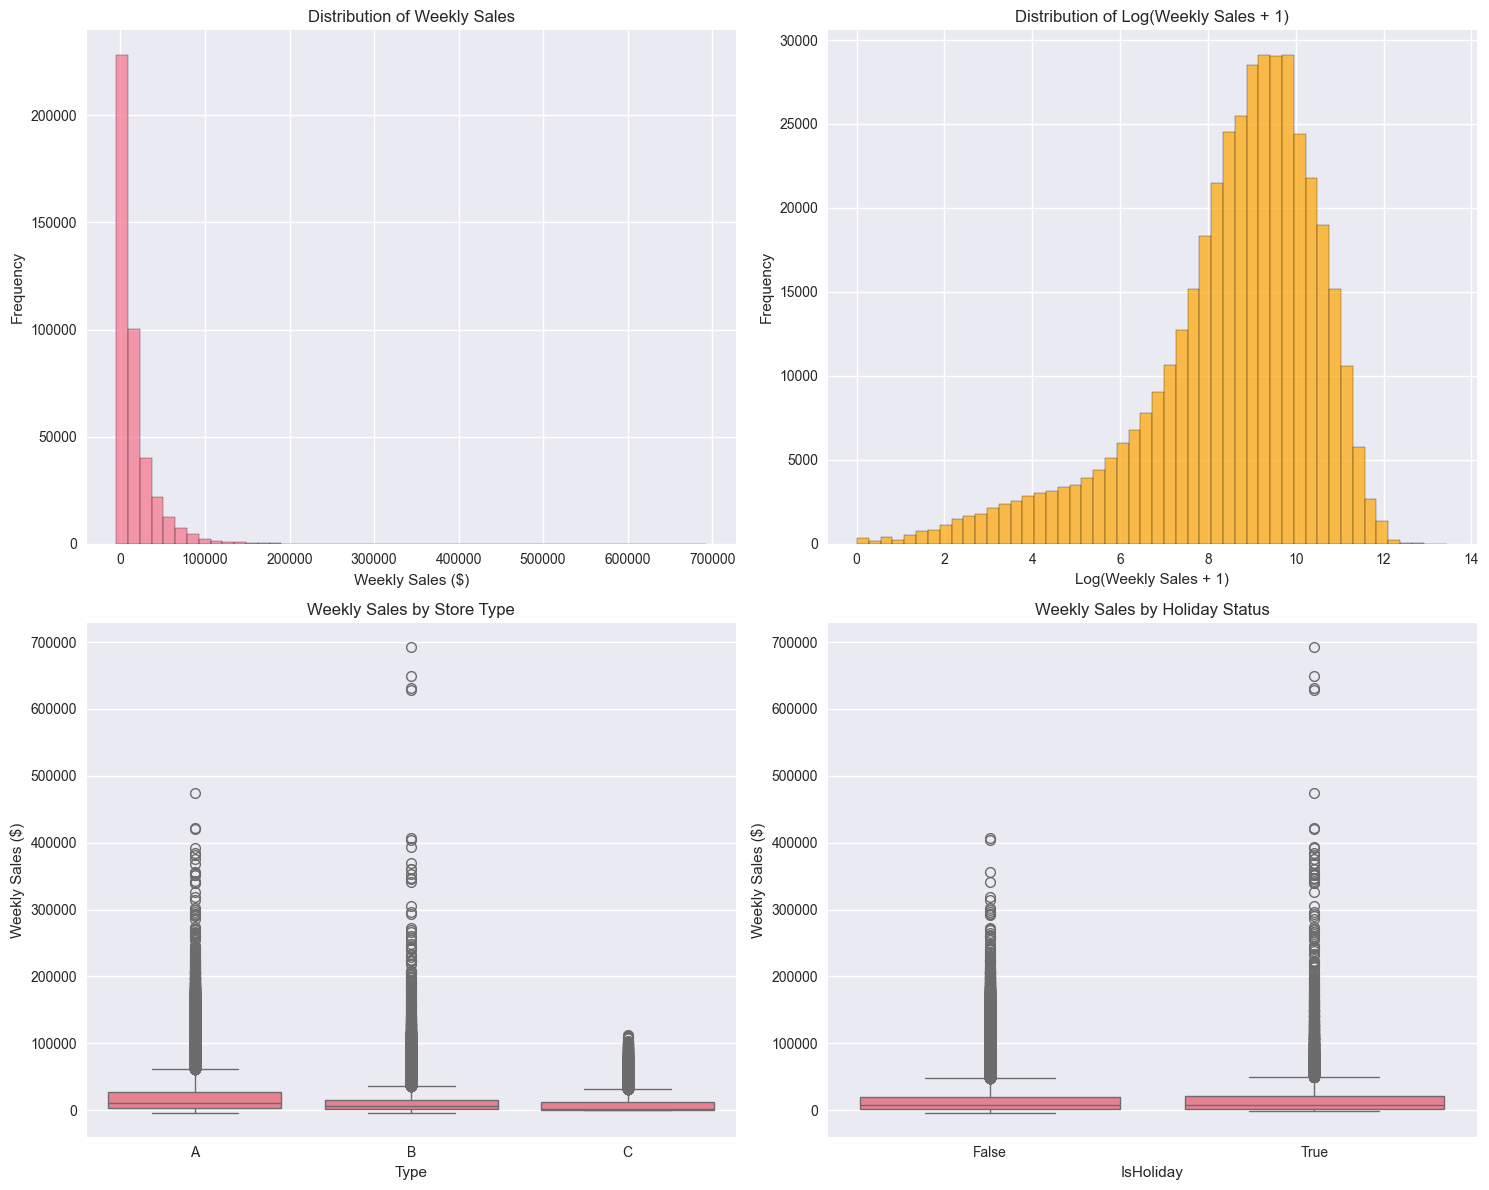

In [9]:
# Sales distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sales distribution
axes[0,0].hist(train_df['Weekly_Sales'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Weekly Sales')
axes[0,0].set_xlabel('Weekly Sales ($)')
axes[0,0].set_ylabel('Frequency')

# Log-transformed sales distribution
positive_sales = train_df[train_df['Weekly_Sales'] > 0]['Weekly_Sales']
axes[0,1].hist(np.log1p(positive_sales), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[0,1].set_title('Distribution of Log(Weekly Sales + 1)')
axes[0,1].set_xlabel('Log(Weekly Sales + 1)')
axes[0,1].set_ylabel('Frequency')

# Box plot by store type
train_with_stores = train_df.merge(stores_df, on='Store')
sns.boxplot(data=train_with_stores, x='Type', y='Weekly_Sales', ax=axes[1,0])
axes[1,0].set_title('Weekly Sales by Store Type')
axes[1,0].set_ylabel('Weekly Sales ($)')

# Sales by holiday
sns.boxplot(data=train_df, x='IsHoliday', y='Weekly_Sales', ax=axes[1,1])
axes[1,1].set_title('Weekly Sales by Holiday Status')
axes[1,1].set_ylabel('Weekly Sales ($)')

plt.tight_layout()
plt.show()

## 4. Time Series Analysis

In [10]:
# Aggregate sales by date
daily_sales = train_df.groupby('Date')['Weekly_Sales'].agg(['sum', 'mean', 'count']).reset_index()
daily_sales.columns = ['Date', 'Total_Sales', 'Avg_Sales', 'Record_Count']

print("=== TIME SERIES OVERVIEW ===")
print(f"Date range: {daily_sales['Date'].min()} to {daily_sales['Date'].max()}")
print(f"Number of weeks: {len(daily_sales)}")
print(f"Average weekly total sales: ${daily_sales['Total_Sales'].mean():,.2f}")
print(f"Peak sales week: {daily_sales.loc[daily_sales['Total_Sales'].idxmax(), 'Date']} (${daily_sales['Total_Sales'].max():,.2f})")
print(f"Lowest sales week: {daily_sales.loc[daily_sales['Total_Sales'].idxmin(), 'Date']} (${daily_sales['Total_Sales'].min():,.2f})")

=== TIME SERIES OVERVIEW ===
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Number of weeks: 143
Average weekly total sales: $47,113,419.49
Peak sales week: 2010-12-24 00:00:00 ($80,931,415.60)
Lowest sales week: 2011-01-28 00:00:00 ($39,599,852.99)


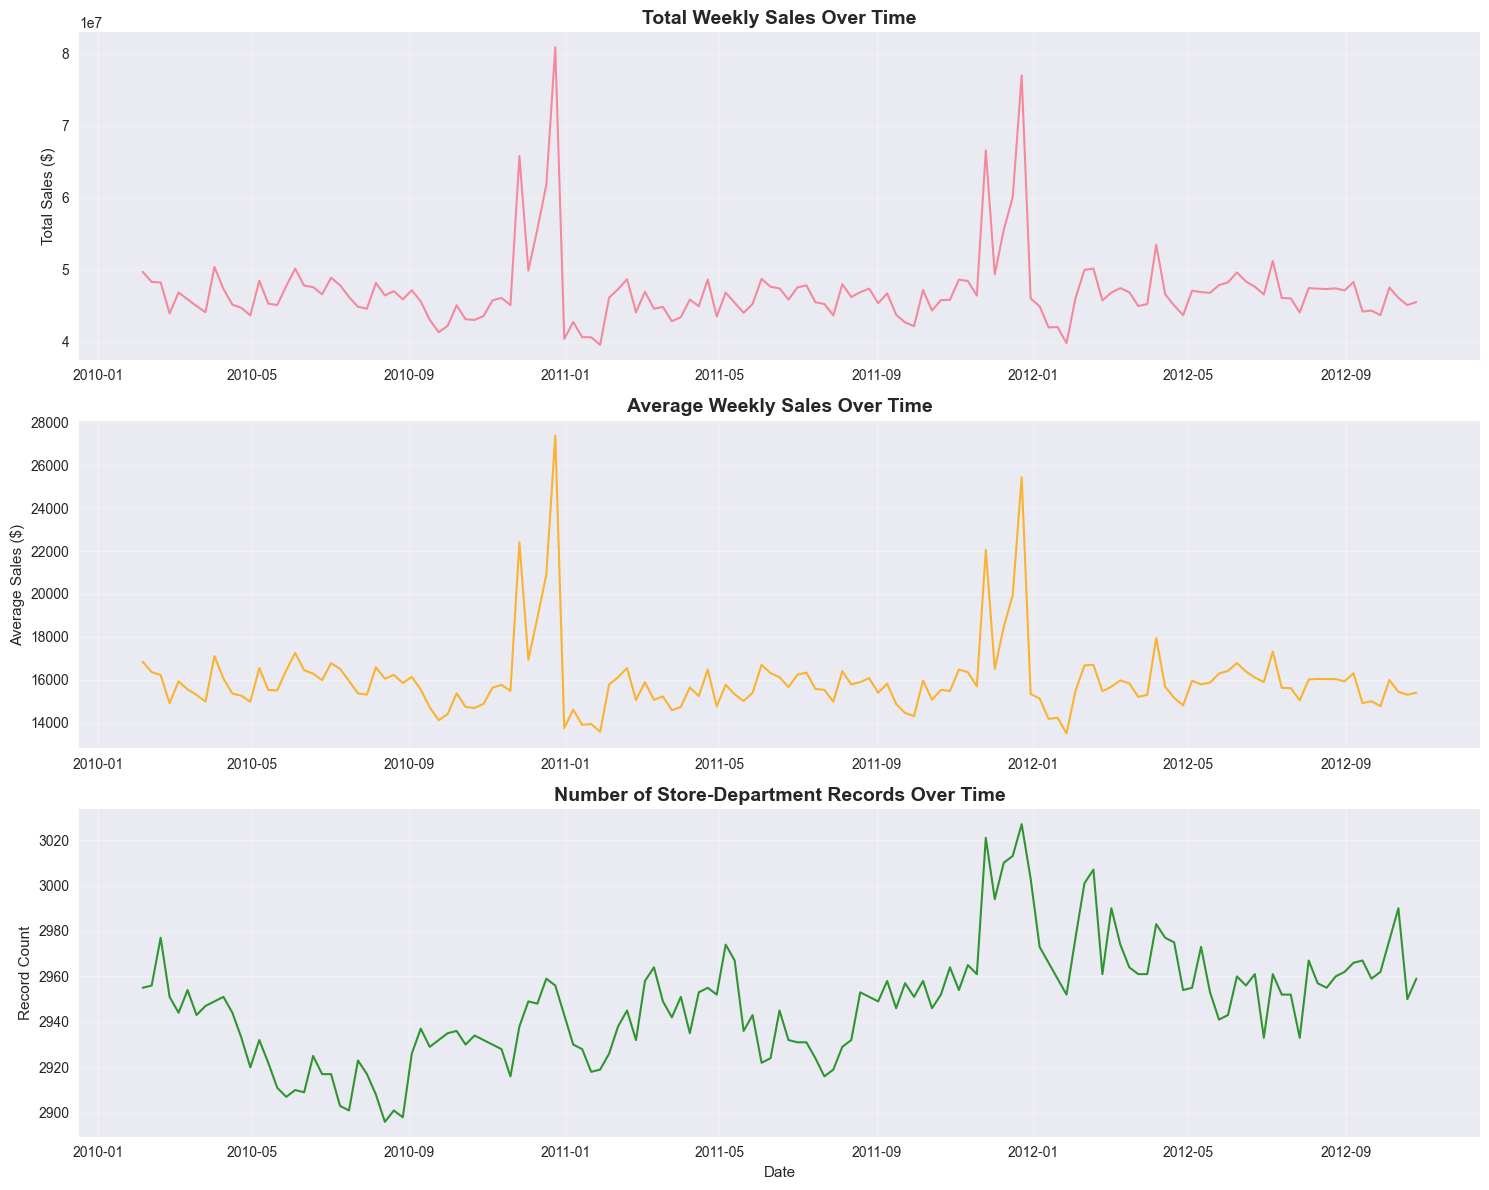

In [11]:
# Time series visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Total sales over time
axes[0].plot(daily_sales['Date'], daily_sales['Total_Sales'], linewidth=1.5, alpha=0.8)
axes[0].set_title('Total Weekly Sales Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Sales ($)')
axes[0].grid(True, alpha=0.3)

# Average sales over time
axes[1].plot(daily_sales['Date'], daily_sales['Avg_Sales'], linewidth=1.5, alpha=0.8, color='orange')
axes[1].set_title('Average Weekly Sales Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Sales ($)')
axes[1].grid(True, alpha=0.3)

# Number of records over time (data completeness)
axes[2].plot(daily_sales['Date'], daily_sales['Record_Count'], linewidth=1.5, alpha=0.8, color='green')
axes[2].set_title('Number of Store-Department Records Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Record Count')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Seasonal Patterns Analysis

In [12]:
# Extract time features
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Week'] = train_df['Date'].dt.isocalendar().week
train_df['DayOfYear'] = train_df['Date'].dt.dayofyear
train_df['Quarter'] = train_df['Date'].dt.quarter

# Seasonal analysis
monthly_sales = train_df.groupby('Month')['Weekly_Sales'].agg(['mean', 'sum', 'std']).reset_index()
quarterly_sales = train_df.groupby('Quarter')['Weekly_Sales'].agg(['mean', 'sum', 'std']).reset_index()
yearly_sales = train_df.groupby('Year')['Weekly_Sales'].agg(['mean', 'sum', 'std']).reset_index()

print("=== SEASONAL PATTERNS ===")
print("\nMonthly Sales (Average):")
for _, row in monthly_sales.iterrows():
    month_name = pd.to_datetime(f"2010-{int(row['Month'])}-01").strftime('%B')
    print(f"{month_name}: ${row['mean']:,.2f}")

print("\nQuarterly Sales (Average):")
for _, row in quarterly_sales.iterrows():
    print(f"Q{int(row['Quarter'])}: ${row['mean']:,.2f}")

=== SEASONAL PATTERNS ===

Monthly Sales (Average):
January: $14,126.08
February: $16,008.78
March: $15,416.66
April: $15,650.34
May: $15,776.34
June: $16,326.14
July: $15,861.42
August: $16,062.52
September: $15,095.89
October: $15,243.86
November: $17,491.03
December: $19,355.70

Quarterly Sales (Average):
Q1: $15,320.77
Q2: $15,913.64
Q3: $15,676.94
Q4: $17,157.23


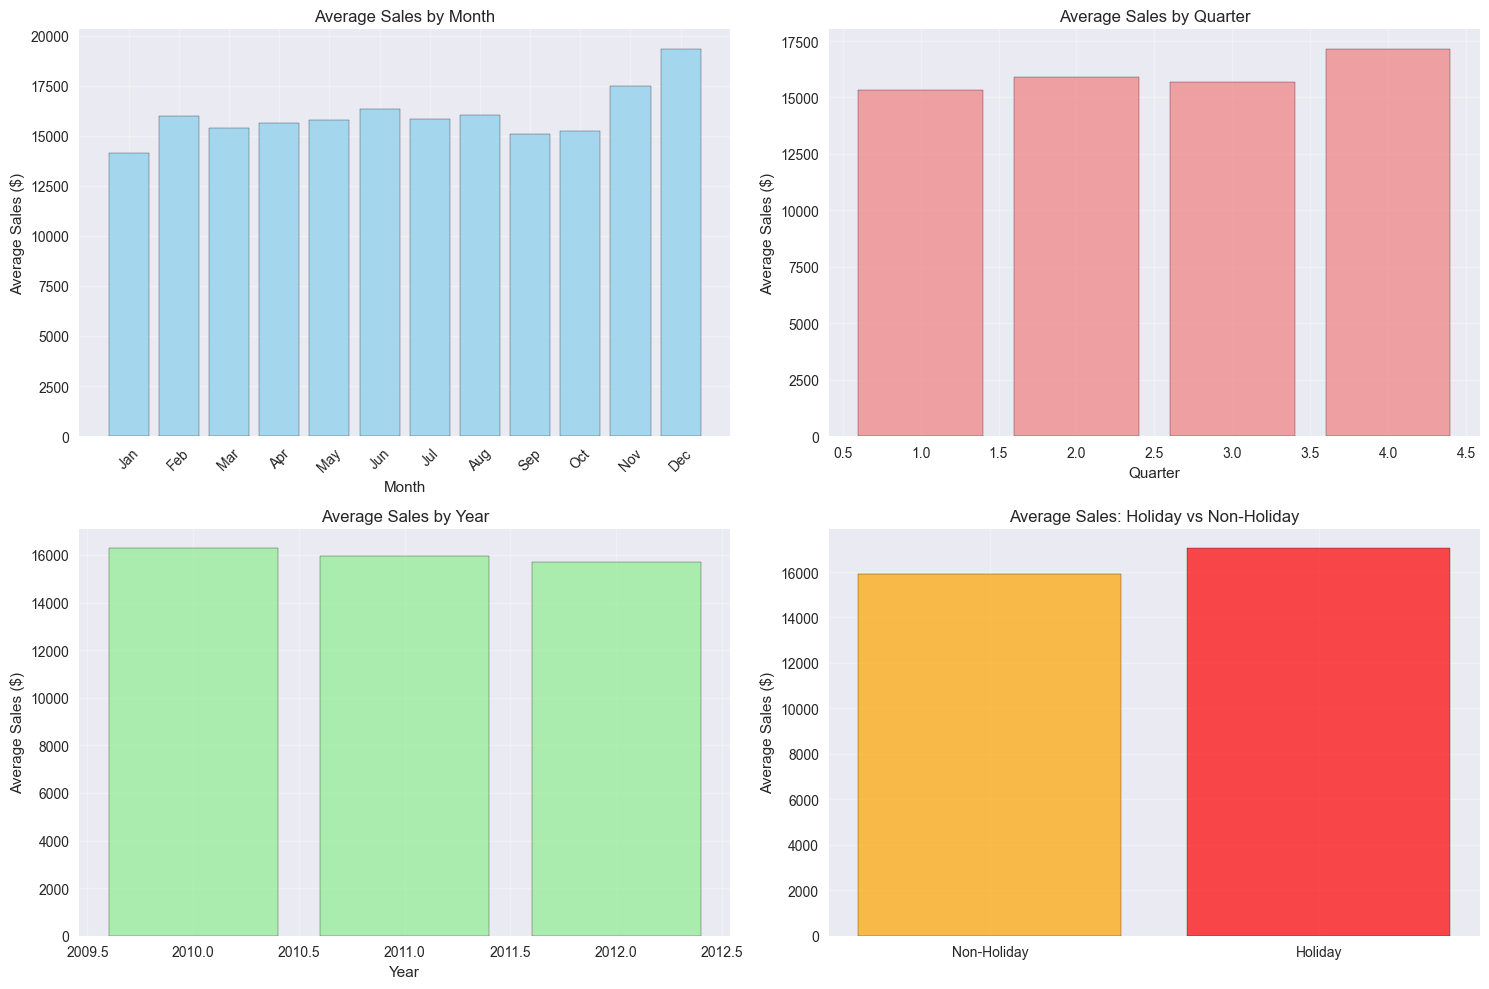

In [13]:
# Seasonal visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly patterns
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0,0].bar(range(1, 13), monthly_sales['mean'], alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Average Sales by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Sales ($)')
axes[0,0].set_xticks(range(1, 13))
axes[0,0].set_xticklabels(month_names, rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Quarterly patterns
axes[0,1].bar(quarterly_sales['Quarter'], quarterly_sales['mean'], alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Average Sales by Quarter')
axes[0,1].set_xlabel('Quarter')
axes[0,1].set_ylabel('Average Sales ($)')
axes[0,1].grid(True, alpha=0.3)

# Yearly patterns
axes[1,0].bar(yearly_sales['Year'], yearly_sales['mean'], alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Average Sales by Year')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Average Sales ($)')
axes[1,0].grid(True, alpha=0.3)

# Holiday vs Non-holiday
holiday_sales = train_df.groupby('IsHoliday')['Weekly_Sales'].mean()
axes[1,1].bar(['Non-Holiday', 'Holiday'], holiday_sales.values, alpha=0.7, color=['orange', 'red'], edgecolor='black')
axes[1,1].set_title('Average Sales: Holiday vs Non-Holiday')
axes[1,1].set_ylabel('Average Sales ($)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Store and Department Analysis

In [14]:
# Store performance analysis
store_performance = train_df.groupby('Store')['Weekly_Sales'].agg(['sum', 'mean', 'std', 'count']).reset_index()
store_performance = store_performance.merge(stores_df, on='Store')
store_performance['cv'] = store_performance['std'] / store_performance['mean']  # Coefficient of variation

print("=== STORE ANALYSIS ===")
print(f"Number of stores: {len(store_performance)}")
print(f"\nTop 5 stores by total sales:")
top_stores = store_performance.nlargest(5, 'sum')[['Store', 'sum', 'Type', 'Size']]
for _, row in top_stores.iterrows():
    print(f"Store {row['Store']}: ${row['sum']:,.0f} (Type {row['Type']}, Size: {row['Size']:,})")

print(f"\nStore performance by type:")
type_performance = store_performance.groupby('Type').agg({
    'sum': ['mean', 'std'],
    'mean': ['mean', 'std'],
    'Size': ['mean', 'std']
}).round(2)
print(type_performance)

=== STORE ANALYSIS ===
Number of stores: 45

Top 5 stores by total sales:
Store 20: $301,397,792 (Type A, Size: 203,742)
Store 4: $299,543,953 (Type A, Size: 205,863)
Store 14: $288,999,911 (Type A, Size: 200,898)
Store 13: $286,517,704 (Type A, Size: 219,622)
Store 2: $275,382,441 (Type A, Size: 202,307)

Store performance by type:
               sum                   mean                Size          
              mean          std      mean      std       mean       std
Type                                                                   
A     1.968643e+08  72556192.97  19626.24  6523.02  177247.73  49392.62
B     1.176883e+08  55898276.21  12087.38  5304.07  101190.71  32371.14
C     6.758392e+07  17225671.35   9575.25  2692.85   40541.67   1304.15


In [15]:
# Department analysis
dept_performance = train_df.groupby('Dept')['Weekly_Sales'].agg(['sum', 'mean', 'std', 'count']).reset_index()
dept_performance['cv'] = dept_performance['std'] / dept_performance['mean']

print("=== DEPARTMENT ANALYSIS ===")
print(f"Number of departments: {len(dept_performance)}")
print(f"\nTop 10 departments by total sales:")
top_depts = dept_performance.nlargest(10, 'sum')[['Dept', 'sum', 'mean']]
for _, row in top_depts.iterrows():
    print(f"Dept {row['Dept']}: ${row['sum']:,.0f} (Avg: ${row['mean']:,.0f})")

print(f"\nBottom 5 departments by total sales:")
bottom_depts = dept_performance.nsmallest(5, 'sum')[['Dept', 'sum', 'mean']]
for _, row in bottom_depts.iterrows():
    print(f"Dept {row['Dept']}: ${row['sum']:,.0f} (Avg: ${row['mean']:,.0f})")

=== DEPARTMENT ANALYSIS ===
Number of departments: 81

Top 10 departments by total sales:
Dept 92.0: $483,943,342 (Avg: $75,205)
Dept 95.0: $449,320,163 (Avg: $69,824)
Dept 38.0: $393,118,137 (Avg: $61,091)
Dept 72.0: $305,725,152 (Avg: $50,567)
Dept 90.0: $291,068,464 (Avg: $45,232)
Dept 40.0: $288,936,022 (Avg: $44,901)
Dept 2.0: $280,611,174 (Avg: $43,607)
Dept 91.0: $216,781,706 (Avg: $33,688)
Dept 13.0: $197,321,570 (Avg: $30,664)
Dept 8.0: $194,280,781 (Avg: $30,191)

Bottom 5 departments by total sales:
Dept 47.0: $-4,963 (Avg: $-8)
Dept 43.0: $14 (Avg: $1)
Dept 39.0: $178 (Avg: $11)
Dept 78.0: $1,715 (Avg: $7)
Dept 51.0: $30,573 (Avg: $22)


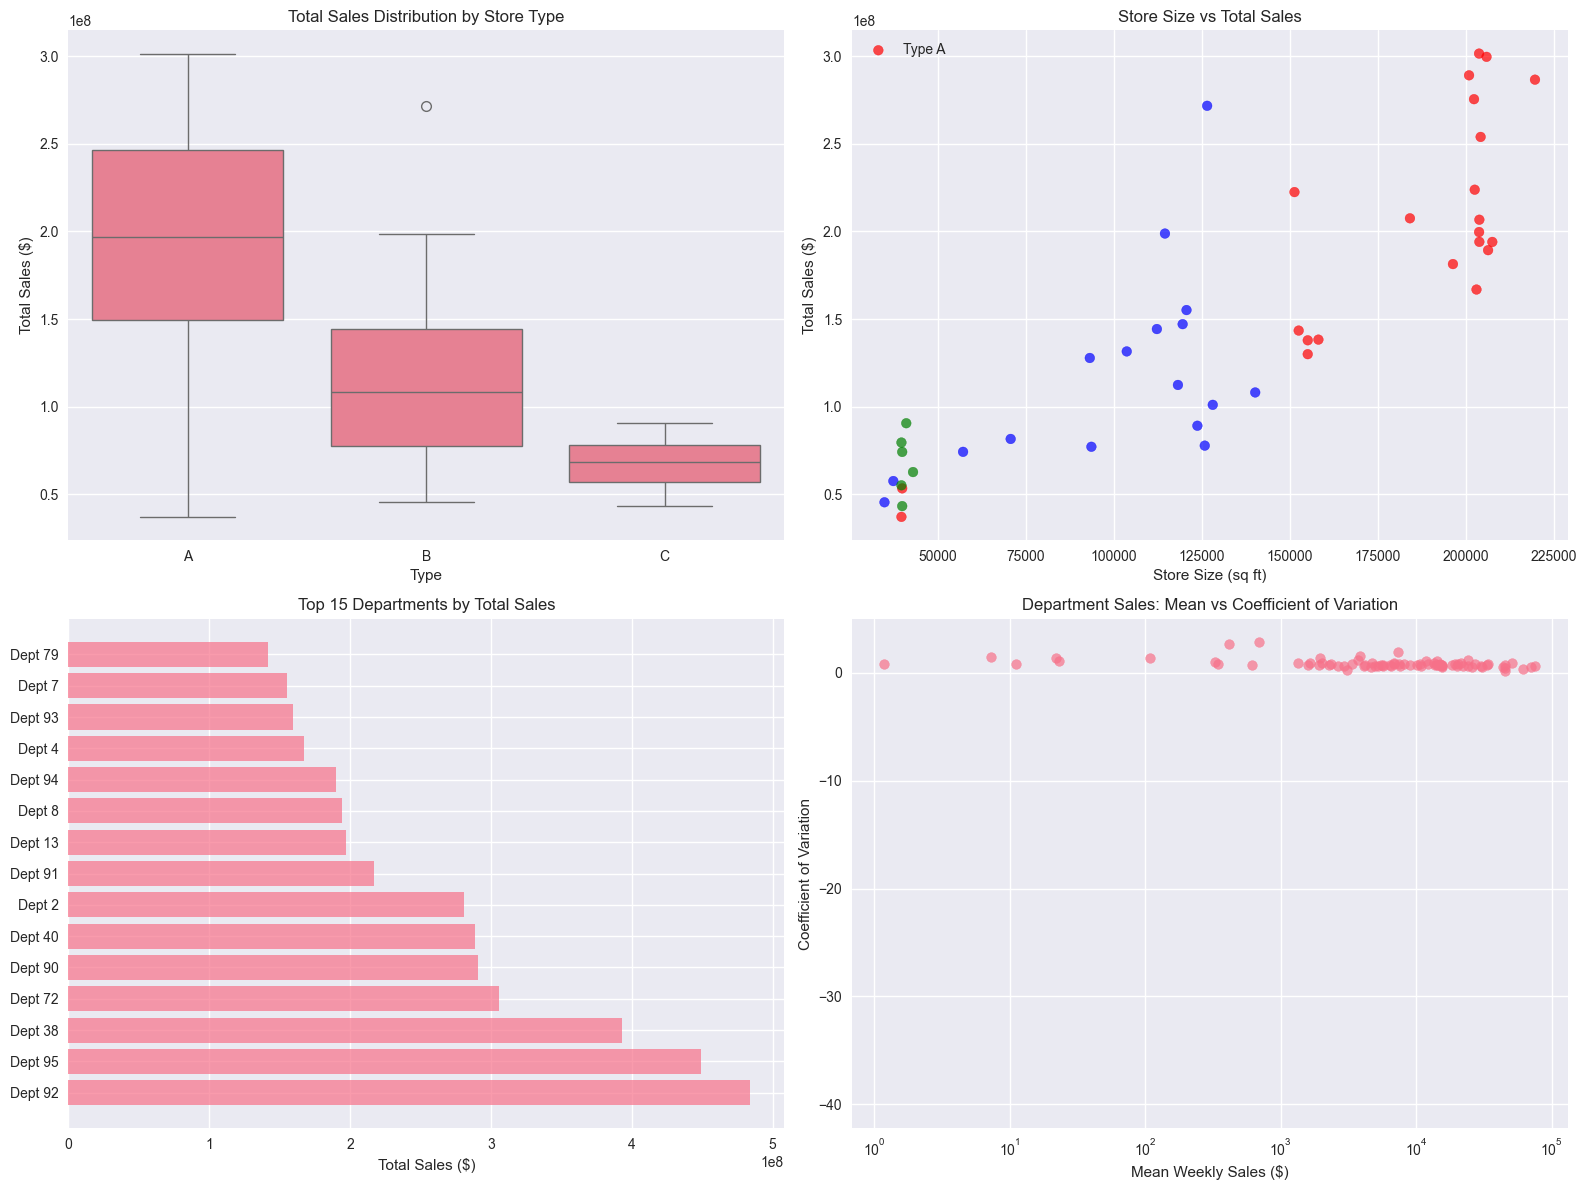

In [16]:
# Store and department visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Store sales by type
sns.boxplot(data=store_performance, x='Type', y='sum', ax=axes[0,0])
axes[0,0].set_title('Total Sales Distribution by Store Type')
axes[0,0].set_ylabel('Total Sales ($)')

# Store size vs sales
axes[0,1].scatter(store_performance['Size'], store_performance['sum'], 
                  c=store_performance['Type'].map({'A': 'red', 'B': 'blue', 'C': 'green'}), alpha=0.7)
axes[0,1].set_title('Store Size vs Total Sales')
axes[0,1].set_xlabel('Store Size (sq ft)')
axes[0,1].set_ylabel('Total Sales ($)')
axes[0,1].legend(['Type A', 'Type B', 'Type C'])

# Top 15 departments
top_15_depts = dept_performance.nlargest(15, 'sum')
axes[1,0].barh(range(len(top_15_depts)), top_15_depts['sum'], alpha=0.7)
axes[1,0].set_yticks(range(len(top_15_depts)))
axes[1,0].set_yticklabels([f"Dept {d}" for d in top_15_depts['Dept']])
axes[1,0].set_title('Top 15 Departments by Total Sales')
axes[1,0].set_xlabel('Total Sales ($)')

# Department sales variability
axes[1,1].scatter(dept_performance['mean'], dept_performance['cv'], alpha=0.7)
axes[1,1].set_title('Department Sales: Mean vs Coefficient of Variation')
axes[1,1].set_xlabel('Mean Weekly Sales ($)')
axes[1,1].set_ylabel('Coefficient of Variation')
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()

## 7. External Features Analysis

In [17]:
# Merge train data with features for analysis
train_with_features = train_df.merge(features_df, on=['Store', 'Date'], how='left')

print("=== EXTERNAL FEATURES ANALYSIS ===")
print(f"Records after merging: {len(train_with_features)}")
print(f"Records with features: {train_with_features.dropna(subset=['Temperature']).shape[0]}")

# Feature statistics
feature_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
print("\nFeature statistics:")
print(train_with_features[feature_cols].describe())

# Correlation with sales
correlations = train_with_features[feature_cols + ['Weekly_Sales']].corr()['Weekly_Sales'].drop('Weekly_Sales')
print("\nCorrelation with Weekly Sales:")
for feature, corr in correlations.items():
    print(f"{feature}: {corr:.4f}")

=== EXTERNAL FEATURES ANALYSIS ===
Records after merging: 421570
Records with features: 421570

Feature statistics:
         Temperature     Fuel_Price            CPI   Unemployment
count  421570.000000  421570.000000  421570.000000  421570.000000
mean       60.090059       3.361027     171.201947       7.960289
std        18.447931       0.458515      39.159276       1.863296
min        -2.060000       2.472000     126.064000       3.879000
25%        46.680000       2.933000     132.022667       6.891000
50%        62.090000       3.452000     182.318780       7.866000
75%        74.280000       3.738000     212.416993       8.572000
max       100.140000       4.468000     227.232807      14.313000

Correlation with Weekly Sales:
Temperature: -0.0023
Fuel_Price: -0.0001
CPI: -0.0209
Unemployment: -0.0259


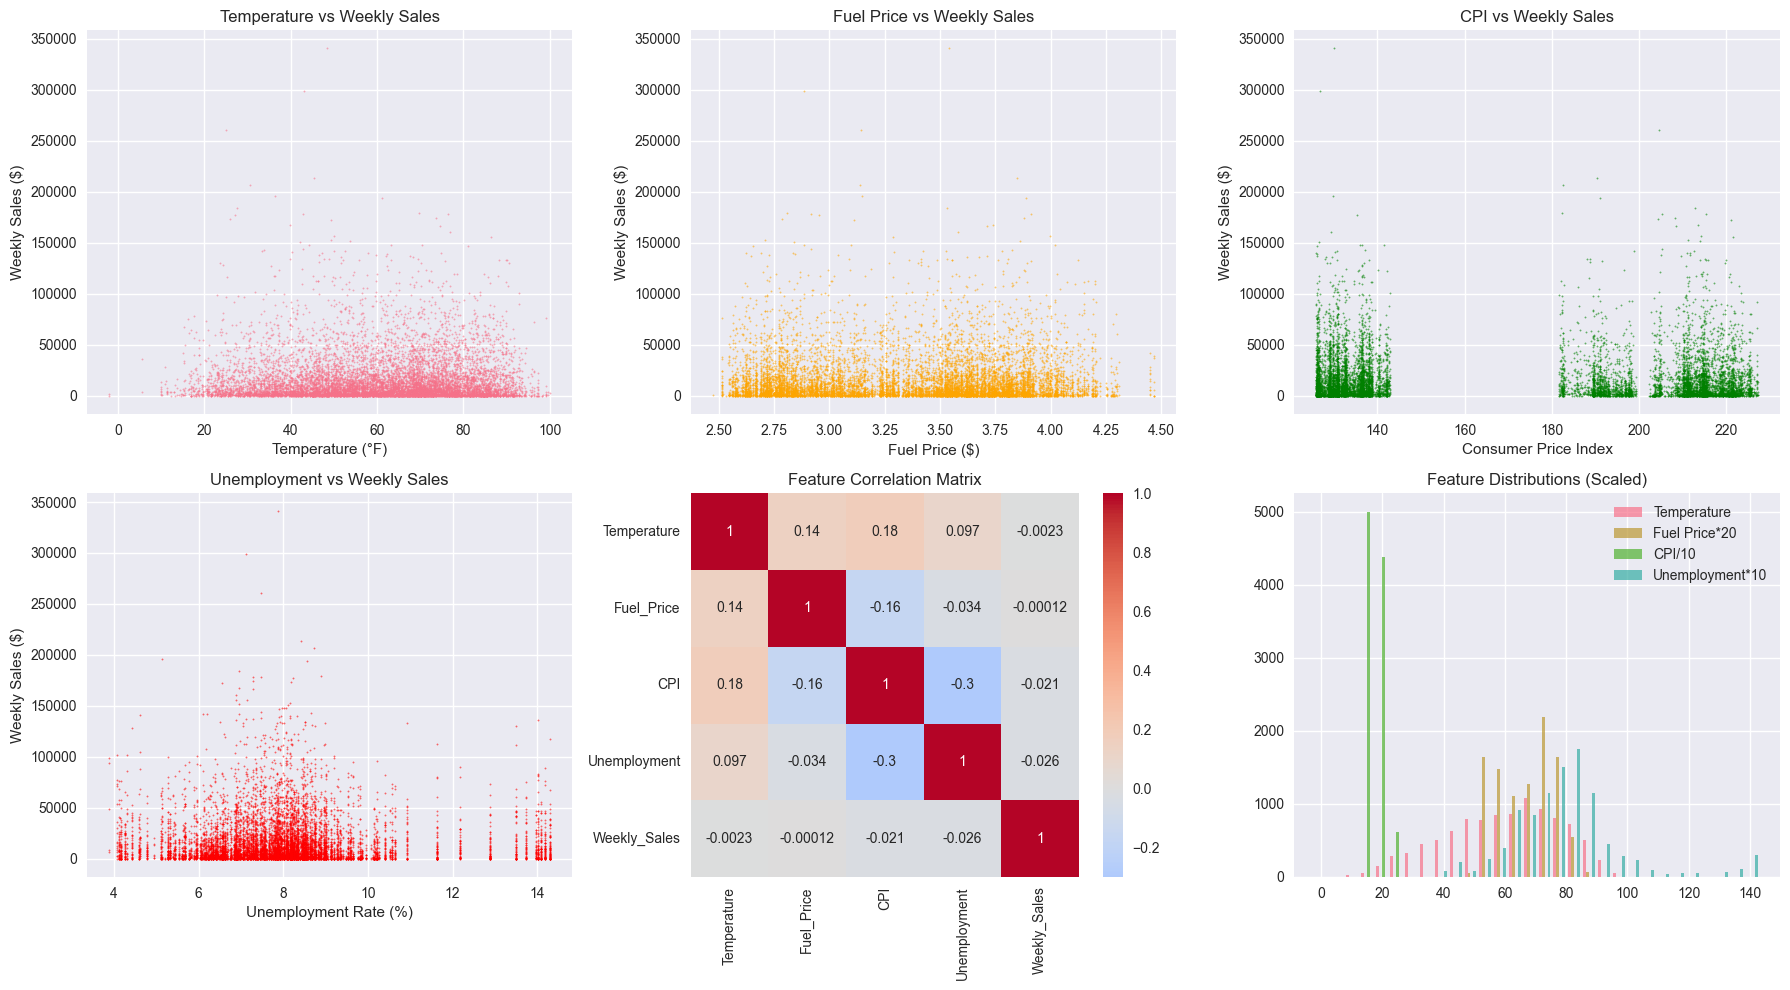

In [18]:
# External features visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Temperature vs Sales
sample_data = train_with_features.dropna(subset=['Temperature']).sample(n=min(10000, len(train_with_features)))
axes[0,0].scatter(sample_data['Temperature'], sample_data['Weekly_Sales'], alpha=0.5, s=1)
axes[0,0].set_title('Temperature vs Weekly Sales')
axes[0,0].set_xlabel('Temperature (°F)')
axes[0,0].set_ylabel('Weekly Sales ($)')

# Fuel Price vs Sales
axes[0,1].scatter(sample_data['Fuel_Price'], sample_data['Weekly_Sales'], alpha=0.5, s=1, color='orange')
axes[0,1].set_title('Fuel Price vs Weekly Sales')
axes[0,1].set_xlabel('Fuel Price ($)')
axes[0,1].set_ylabel('Weekly Sales ($)')

# CPI vs Sales
axes[0,2].scatter(sample_data['CPI'], sample_data['Weekly_Sales'], alpha=0.5, s=1, color='green')
axes[0,2].set_title('CPI vs Weekly Sales')
axes[0,2].set_xlabel('Consumer Price Index')
axes[0,2].set_ylabel('Weekly Sales ($)')

# Unemployment vs Sales
axes[1,0].scatter(sample_data['Unemployment'], sample_data['Weekly_Sales'], alpha=0.5, s=1, color='red')
axes[1,0].set_title('Unemployment vs Weekly Sales')
axes[1,0].set_xlabel('Unemployment Rate (%)')
axes[1,0].set_ylabel('Weekly Sales ($)')

# Feature correlation heatmap
corr_matrix = train_with_features[feature_cols + ['Weekly_Sales']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Feature Correlation Matrix')

# Feature distributions
axes[1,2].hist([sample_data['Temperature'], sample_data['Fuel_Price']*20, 
                sample_data['CPI']/10, sample_data['Unemployment']*10], 
               bins=30, alpha=0.7, label=['Temperature', 'Fuel Price*20', 'CPI/10', 'Unemployment*10'])
axes[1,2].set_title('Feature Distributions (Scaled)')
axes[1,2].legend()

plt.tight_layout()
plt.show()

## 8. Key Insights and Conclusions

### Data Quality
- **Missing Values**: Features dataset has significant missing values in markdown columns
- **Negative Sales**: Some departments show negative sales (likely returns/refunds)
- **Data Completeness**: Good coverage across stores and time periods

### Sales Patterns
- **Seasonality**: Clear seasonal patterns with Q4 showing highest sales (holiday effect)
- **Holiday Impact**: Holiday weeks show different sales patterns
- **Store Types**: Type A stores generally have higher sales volumes
- **Department Variation**: Significant variation in sales across departments

### External Factors
- **Economic Indicators**: CPI and unemployment show some correlation with sales
- **Weather**: Temperature shows weak correlation with sales
- **Fuel Prices**: Minimal direct correlation with sales

### Recommendations for Modeling
1. **Feature Engineering**: Create lag features, rolling averages, and seasonal indicators
2. **Data Preprocessing**: Handle missing values and negative sales appropriately
3. **Model Strategy**: Consider hierarchical models (store-level, department-level)
4. **Validation**: Use time-aware cross-validation to prevent data leakage
5. **External Features**: Include economic indicators and holiday flags

### Next Steps
- Detailed feature engineering
- Baseline model development
- Advanced time series modeling
- Model evaluation and selection